# Pendahuluan

<p align="justify">Cuaca dapat berubah-ubah yaitu hanya dalam beberapa jam, dan ditandai dengan
perbedaan antara siang dan malam. Cuaca disebabkan oleh perbedaan suhu dan kelembaban
dari satu tempat ke tempat lain. Prediksi cuaca yang lengkap dan akurat sangat dibutuhkan
agar dapat meningkatkan kinerja dari berbagai bidang akivitas manusia. Informasi cuaca sangat
bermanfaat dalam berbagai bidang antara lain bidang transportasi, pertanian dan industry
</p>


# Load Data

In [ ]:
from google.colab import files

In [ ]:
uploaded = files.upload()
for fn in uploaded.keys():
  print('upload api kaggle json = '.format(
      name = fn, length=len(uploaded[fn])
  ))

# authentic kaggle API.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
upload api kaggle json = 


In [ ]:
!kaggle datasets download -d sumanthvrao/daily-climate-time-series-data

  0% 0.00/22.0k [00:00<?, ?B/s]
100% 22.0k/22.0k [00:00<00:00, 19.7MB/s]


In [ ]:
!unzip /content/daily-climate-time-series-data.zip

Archive:  /content/daily-climate-time-series-data.zip
  inflating: DailyDelhiClimateTest.csv  
  inflating: DailyDelhiClimateTrain.csv  


#import library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.optimizers import RMSprop
from keras.callbacks import Callback

#load data

##train

In [ ]:
dftrain = pd.read_csv("/content/DailyDelhiClimateTrain.csv",parse_dates=['date'])
dftrain.head() 

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [ ]:
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1462 non-null   datetime64[ns]
 1   meantemp      1462 non-null   float64       
 2   humidity      1462 non-null   float64       
 3   wind_speed    1462 non-null   float64       
 4   meanpressure  1462 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 57.2 KB


#Preprocessing Data

* Date = Date of format YYYY-MM-DD
* Meantemp = Rata-rata suhu rata-rata dari beberapa interval 3 jam dalam sehari.
*

In [ ]:
dftrain.isna().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [ ]:
dftrain.shape

(1462, 5)

In [ ]:
# memisahkan data train dan data test
train_df = dftrain2[0:-439] # train 70%
test_df = dftrain2[-439:] # test 30%

In [ ]:
train_df.shape

(1023, 1)

In [ ]:
test_df.shape

(439, 1)

In [ ]:
dftrain = train_df.set_index('date')
dftest = test_df.set_index('date')

#Modelling

##RNN

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
# membuat object scaler
scaler = StandardScaler()

# melakukan scaling terhadap data train
train_scale = scaler.fit_transform(dftrain)

# melakukan scaling terhadap data test
test_scale = scaler.transform(dftest)

In [ ]:
train_scale

array([[-2.08465208,  1.37450237, -1.46237736,  1.04573037],
       [-2.4364168 ,  1.81293011, -0.83467634,  1.32744819],
       [-2.46798543,  1.52064495, -0.48642164,  1.44189605],
       ...,
       [ 0.1960203 ,  0.62708745,  0.87833659,  0.71009001],
       [ 0.36996988,  0.30974927, -0.73417196,  0.52379781],
       [ 0.31198669,  0.22623922, -0.84851826,  0.27855239]])

In [ ]:
import torch

In [ ]:
# merubah data ke bentuk tensor lalu reshape ke bentuk view(-1)
train_tensor = torch.FloatTensor(train_scale).reshape(-1)
test_tensor = torch.FloatTensor(test_scale).reshape(-1)

In [ ]:
train_tensor

tensor([-2.0847,  1.3745, -1.4624,  ...,  0.2262, -0.8485,  0.2786])

In [ ]:
# function for making sequential data
def input_data(data, seq_size):
    out = []
    length = len(data)
    
    for i in range(length-seq_size):
        feature = data[i : i+seq_size]
        target = data[i+seq_size : i+seq_size+1]
        out.append((feature, target))
    
    return out

In [ ]:
# sebagai input di fungsi input_data
seq_size = 1

# apply fungsi custom ke data train dan test
train_dataset = input_data(train_tensor, seq_size)
test_dataset = input_data(test_tensor, seq_size)

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
# setting batch size
bs = 16

# buat DataLoader untuk data train dan test
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

In [ ]:
from torch import nn

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super().__init__()
        self.rnn = nn.RNN(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers
        ) # RNN block
        self.fc = nn.Linear(
            in_features = hidden_size,
            out_features = output_size
        ) # fully connected layer
        
    def forward(self, x, hidden): # langkah feedforward
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        
        return x, hidden

In [ ]:
config = {
    "input_size": seq_size, 
    "output_size": 1, 
    "hidden_size": 64, 
    "num_layers": 2
}

In [ ]:
# kunci randomness awal
torch.manual_seed(2102)

# buat model dan masukan konfigurasi
model = RNN(
    input_size = config["input_size"], 
    output_size = config["output_size"], 
    hidden_size = config["hidden_size"], 
    num_layers = config["num_layers"]
)

In [ ]:
criterion = nn.MSELoss()

In [ ]:
from torch import optim
optimizer = optim.SGD(params = model.parameters(), lr = 0.002)

In [ ]:
model.parameters

<bound method Module.parameters of RNN(
  (rnn): RNN(1, 64, num_layers=2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)>

In [ ]:
epochs = 30
train_cost, test_cost = [], []

for i in range(epochs):
    # training
    model.train()
    cost = 0
    for feature, target in train_loader: # iterasi untuk minibatch
        # feedforward
        output, hidden = model.forward(feature, None)
        # hitung loss
        loss = criterion(output, target)
        # backpropagation
        loss.backward()
        # update weight
        optimizer.step()
        # reset optimizer (kasus khusus pada pytorch)
        optimizer.zero_grad()
        
        # perhitungan loss total per minibatch (dikali jumlah data agar bisa dibagi dengan total data di akhir)
        cost += loss.item() * feature.shape[0] 
        # .item() buat ambil skalar nilai 
    train_cost.append(cost / len(train_dataset)) # cost (MSE) per epoch dicatat
    
    # evaluasi
    with torch.no_grad(): # memastikan tidak terjadi perhitungan gradient
        model.eval()
        cost = 0
        for feature, target in test_loader:
            # feedforward
            output, hidden = model.forward(feature, None)
            # hitung loss sebagai pembanding
            loss = criterion(output, target)
            # data test ga backpropagation dan update weight nanti leakage
            
            # perhitungan loss total per minibatch (dikali jumlah data agar bisa dibagi dengan rata2)
            cost += loss.item() * feature.shape[0]
        test_cost.append(cost / len(test_dataset)) # cost (MSE) per epoch dicatat

    print(f'\rEpoch: {i+1}/{epochs} | train_cost: {train_cost[-1]:4f} | test_cost: {test_cost[-1]:4f}', end=' ')

Epoch: 30/30 | train_cost: 0.371581 | test_cost: 470.278928 

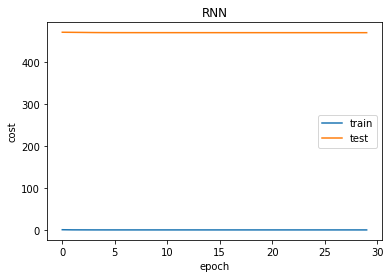

In [ ]:
plt.plot(train_cost, label = "train")
plt.plot(test_cost, label = "test")
plt.title("RNN")
plt.xlabel("epoch")
plt.ylabel("cost")
plt.legend()

##LSTM

* Catatan
dalam pembuatan model LSTM dengan Pytorch menggunakan 1 inputan dan 1 output yaitu "meantemp"

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch import Tensor
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler


In [ ]:
def scaling_window(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [ ]:
dftrain2 = dftrain.copy()
dftrain2 = dftrain2.drop(['humidity', 'wind_speed','meanpressure'], axis=1)

In [ ]:
dftrain2

,meantemp
date,
2013-01-01,10.000000
2013-01-02,7.400000
2013-01-03,7.166667
2013-01-04,8.666667
2013-01-05,6.000000
...,...
2016-12-28,17.217391
2016-12-29,15.238095
2016-12-30,14.095238


In [ ]:
sc = MinMaxScaler()
training_data = sc.fit_transform(dftrain2)

In [ ]:
seq_length = 1
x, y = scaling_window(training_data, seq_length)

train_size = int(len(y) * 0.80)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [ ]:
trainX.shape

torch.Size([1168, 1, 1])

In [ ]:
dataX.shape

torch.Size([1460, 1, 1])

In [ ]:
dataY.shape

torch.Size([1460, 1])

In [ ]:
#modelling
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)
        
        return out

In [ ]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
     

Epoch: 0, loss: 0.04819
Epoch: 100, loss: 0.00251
Epoch: 200, loss: 0.00249
Epoch: 300, loss: 0.00249
Epoch: 400, loss: 0.00251
Epoch: 500, loss: 0.00249
Epoch: 600, loss: 0.00249
Epoch: 700, loss: 0.00249
Epoch: 800, loss: 0.00249
Epoch: 900, loss: 0.00249
Epoch: 1000, loss: 0.00249
Epoch: 1100, loss: 0.00249
Epoch: 1200, loss: 0.00249
Epoch: 1300, loss: 0.00249
Epoch: 1400, loss: 0.00249
Epoch: 1500, loss: 0.00249
Epoch: 1600, loss: 0.00249
Epoch: 1700, loss: 0.00249
Epoch: 1800, loss: 0.00249
Epoch: 1900, loss: 0.00249


In [ ]:
lstm.parameters

<bound method Module.parameters of LSTM(
  (lstm): LSTM(1, 2, batch_first=True)
  (fc): Linear(in_features=2, out_features=1, bias=True)
)>

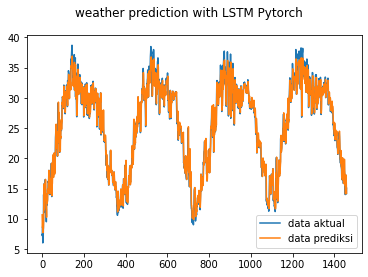

In [ ]:
plt.plot(dataY_plot,label="data aktual")
plt.plot(data_predict,label="data prediksi")
plt.suptitle('weather prediction with LSTM Pytorch')
plt.legend()
plt.show()
     

In [ ]:
print('LSTM mae: '+str(loss.item()))

LSTM mae: 0.3852856457233429


#Kesimpulan

* Berdasarkan Pemodelan menggunakan RNN dan LSTM dibangun menggunakan Pytorch dapat diketahui:
** Pemodelan LSTM jauh lebih baik dalam melakukan pemodelan dikarenakan model RNN memiliki gradient descent terbatas dalam melakukan update bobot

#Referensi

* <p align="justify">Priatna, M. A. and Djamal, E. C. (2020) ‘Precipitation prediction using recurrent neural networks and long short-term memory’, Telkomnika (Telecommunication Computing Electronics and Control), 18(5), pp. 2525–2532. doi: 10.12928/TELKOMNIKA.V18I5.14887. </p>

* Lattifia, T., Wira Buana, P. and Rusjayanthi, N. K. D. (2022) ‘Model Prediksi Cuaca Menggunakan Metode LSTM’, JITTER Jurnal Ilmiah Teknologi dan Komputer, 3(1), pp. 994–1000. Available at: https://ojs.unud.ac.id/index.php/jitter/article/view/85000/43781.